In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd "/content/drive/MyDrive/Graduation Project/salah datasets/"
%ls

/content/drive/MyDrive/Graduation Project/salah datasets
 classified_dataset.csv
'Classifying Dialogues (Using Google APIs).ipynb'
'Copy of Classifying Dialogues (Using Google APIs).ipynb'
 dataset_train.json
 dialogsum.dev.jsonl
 dialogsum.test.jsonl
 dialogsum.train.jsonl
 dialogues_test.txt
 dialogues_train.txt
 dialogues_validation.txt
 errors.json
 fully_classified_dataset.csv
'Graduation Project'@
 merged_dataset.csv
'Merging The Datasets.ipynb'
 server-file.json
 Untitled0.ipynb


In [3]:
%pip install google-cloud-language==2.0.0

In [4]:
SEED = 512

In [5]:
import argparse
import io
import json
import os
import collections

import random
random.seed(SEED)

from google.cloud import language_v1
import numpy
import six
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/content/drive/MyDrive/Graduation Project/salah datasets/server-file.json"

In [7]:
def classify(row, verbose=True):
    """Classify the input text into categories. """

    language_client = language_v1.LanguageServiceClient()

    text = row['dialogue']

    document = language_v1.Document(
        content=text, type_=language_v1.Document.Type.PLAIN_TEXT
    )
    response = language_client.classify_text(request={"document": document})
    categories = response.categories

    result = {}

    for category in categories:
        # Turn the categories into a dictionary of the form:
        # {category.name: category.confidence}, so that they can
        # be treated as a sparse vector.
        result[category.name] = category.confidence

    if verbose:
        topics = ';'.join(row[['topic', 'topic1', 'topic2', 'topic3']].astype(str))

        print(text)
        print(f"Topics in the dataset: {topics}")
        print(f"# Categories found: {len(categories)}")
        for category in categories:
            print(u"=" * 20)
            print(u"{:<16}: {}".format("category", category.name))
            print(u"{:<16}: {}".format("confidence", category.confidence))

    return result

In [8]:
dataset_df = pd.read_csv("merged_dataset.csv")

# shuffle the rows and reset the index
dataset_df = dataset_df.sample(frac=1, random_state=SEED).reset_index(drop=True)

# drop the old index since pandas converted it to a new  column
dataset_df = dataset_df.drop(columns=["Unnamed: 0"])

# add a column that we will fill later for the classified categories from google
dataset_df['Google Classification'] = [np.nan]*dataset_df.shape[0]

dataset_df

,topic,topic1,topic2,topic3,summary,summary1,summary2,summary3,dialogue,fname,Google Classification
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#Person1#:Actually I have a passion for Chines...,NaN,NaN
1,complaint,NaN,NaN,NaN,#Person1# complains to #Person2# because #Pers...,NaN,NaN,NaN,"#Person1#: Mr. Brown, are your children always...",train_6415,NaN
2,ask for money,NaN,NaN,NaN,#Person1# asks #Person2# to lend Jenny and #Pe...,NaN,NaN,NaN,"#Person1#: Dad, can you lend Jenny and me some...",train_11159,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"#Person1#:I don't have any more cash , and I h...",NaN,NaN
4,Mars,NaN,NaN,NaN,#Person1# tells #Person2# that there is water ...,NaN,NaN,NaN,#Person1#: I'm reading an interesting report o...,train_2107,NaN
...,...,...,...,...,...,...,...,...,...,...,...
26573,job interview,NaN,NaN,NaN,Sunlin asks #Person2# whether there're vacanci...,NaN,NaN,NaN,"#Person1#: Excuse me, I am Sunlin. I am here a...",train_3309,NaN
26574,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#Person1#:Hello . I'm Jason .\n#Person2#:Hi . ...,NaN,NaN
26575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#Person1#:Okay . This trail looks the best . I...,NaN,NaN
26576,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"#Person1#:Daddy , I want to buy a ten-speed-sp...",NaN,NaN


In [9]:
dataset_df.head()

,topic,topic1,topic2,topic3,summary,summary1,summary2,summary3,dialogue,fname,Google Classification
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#Person1#:Actually I have a passion for Chines...,NaN,NaN
1,complaint,NaN,NaN,NaN,#Person1# complains to #Person2# because #Pers...,NaN,NaN,NaN,"#Person1#: Mr. Brown, are your children always...",train_6415,NaN
2,ask for money,NaN,NaN,NaN,#Person1# asks #Person2# to lend Jenny and #Pe...,NaN,NaN,NaN,"#Person1#: Dad, can you lend Jenny and me some...",train_11159,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"#Person1#:I don't have any more cash , and I h...",NaN,NaN
4,Mars,NaN,NaN,NaN,#Person1# tells #Person2# that there is water ...,NaN,NaN,NaN,#Person1#: I'm reading an interesting report o...,train_2107,NaN


In [10]:
for i in range(5):
    row = dataset_df.iloc[i]
    print(classify(row))
    print("-"*50)

#Person1#:Actually I have a passion for Chinese literature .
#Person2#:You do ?
#Person1#:Yeah , those classics from the great writers .
#Person2#:But I find Japanese ones better .
Topics in the dataset: nan;nan;nan;nan
# Categories found: 1
category        : /Books & Literature
confidence      : 0.5199999809265137
{'/Books & Literature': 0.5199999809265137}
--------------------------------------------------
#Person1#: Mr. Brown, are your children always kicking up a row like this? I cannot concentrate on my paper. 
#Person2#: Sorry, Mr. Black. I'm trying to make them quiet. 
#Person1#: I'm afraid if the noise goes on, I shall have no alternative but to leave. 
#Person2#: Sorry, sir. Believe me, everything will be all right. 
Topics in the dataset: complaint;nan;nan;nan
# Categories found: 0
{}
--------------------------------------------------
#Person1#: Dad, can you lend Jenny and me some money?
#Person2#: For what?
#Person1#: We want to get tickets for a rock concert. We'll pay you 

In [11]:
# get a random sample from the rows of the dataset
sample_size = dataset_df.shape[0]
sample_rows = range(dataset_df.shape[0])

In [12]:
row_index_to_classification = dict()

get_max_category = lambda d: np.nan if len(d)==0 else list(sorted(d.items(), reverse=True))[0][0]
error_rows = []

for index, i in enumerate(sample_rows):
    # categorized, skip

    if type(dataset_df.iloc[i]['Google Classification']) == str:
        continue

    row = dataset_df.iloc[i]
    try:
        classification = classify(row, False)

    except Exception as error:
        print(f"Error on row {i}:", error)
        row_index_to_classification[i] = {}
        error_rows.append(i)

        continue

    row_index_to_classification[i] = classification

    category = get_max_category(classification)

    topics_in_dataset = ';'.join(row[['topic', 'topic1', 'topic2', 'topic3']].astype(str))
    dataset_df.iloc[i, dataset_df.columns.get_loc('Google Classification')] = category

    if (index%(sample_size//100))==0:
        print(f"Progress: {(index/sample_size)*100}%")
        dataset_df.to_csv("fully_classified_dataset.csv")
        with open("errors.json", "w+") as fh:
            json.dump({"errors": error_rows}, fh)

Progress: 0.0%
Error on row 30: 400 Invalid text content: too few tokens (words) to process.
Error on row 98: 400 Invalid text content: too few tokens (words) to process.
Progress: 0.9970652419294154%
Progress: 1.9941304838588307%
Error on row 584: 400 Invalid text content: too few tokens (words) to process.
Progress: 2.9911957257882458%
Error on row 807: 400 Invalid text content: too few tokens (words) to process.
Error on row 1001: 400 Invalid text content: too few tokens (words) to process.
Progress: 3.9882609677176615%
Error on row 1072: 400 Invalid text content: too few tokens (words) to process.
Error on row 1111: 400 Invalid text content: too few tokens (words) to process.
Error on row 1159: 400 Invalid text content: too few tokens (words) to process.
Error on row 1241: 400 Invalid text content: too few tokens (words) to process.
Progress: 4.985326209647076%
Progress: 5.9823914515764915%
Error on row 1650: 400 Invalid text content: too few tokens (words) to process.
Error on row

In [13]:
# dataset_df.iloc[sample_rows][['topic', 'topic1', 'topic2', 'topic3', 'dialogue', 'Google Classification']]
api_results = dataset_df.iloc[sample_rows][['dialogue', 'topic', 'Google Classification']]

mask1 = ~api_results['topic'].isnull()
mask2 = ~api_results['Google Classification'].isnull()

api_results[mask1 & mask2]

,dialogue,topic,Google Classification
2,"#Person1#: Dad, can you lend Jenny and me some...",ask for money,/Arts & Entertainment/Music & Audio/Rock Music
4,#Person1#: I'm reading an interesting report o...,Mars,/Science/Astronomy
15,#Person1#: This is a nice set of wheels. How m...,new car,/Autos & Vehicles/Vehicle Parts & Services
19,#Person1#: I am so happy to know that the prom...,record sale,/Business & Industrial/Business Services
23,"#Person1#: Hey Joe, how have you been?\n#Perso...",watch a movie,/Arts & Entertainment
...,...,...,...
26552,#Person1#: Verry sorry to have kept you waitin...,haircut,/Online Communities
26560,"#Person1#: Grandpa, this restaurant looks real...",Chinese restaurant,/Food & Drink/Restaurants
26563,#Person1#: I saw a vacancy board outside for a...,apply for assistant,/Jobs & Education/Jobs
26571,#Person1#: Our current apartment is valued at ...,new apartment,/Real Estate/Real Estate Listings


In [14]:
classification_results = api_results['Google Classification'].isnull().value_counts()
classification_results

True     14505
False    12073
Name: Google Classification, dtype: int64

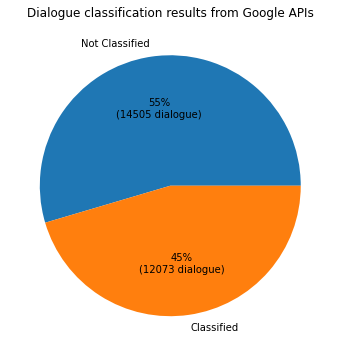

In [15]:
labels = ["Not Classified", "Classified"]

formatter = lambda x, total=api_results.shape[0]:'{:.0f}%\n({:.0f} dialogue)'.format(x, total*x/100)

plt.figure(figsize=(9, 6))
plt.pie(classification_results.to_list(), labels=labels, autopct=formatter)
plt.title("Dialogue classification results from Google APIs", fontsize=12)
plt.show()

In [16]:
not_nan_mask = ~dataset_df['Google Classification'].isnull()
not_nan_mask &= (dataset_df['Google Classification']!="")
classified_categories = dataset_df[not_nan_mask]['Google Classification'].apply(lambda x: x.split("/")[1])
classified_categories = classified_categories.value_counts().to_dict().items()
classified_categories = list(classified_categories)
classified_categories_labels, classified_categories_counts = list(zip(*classified_categories))

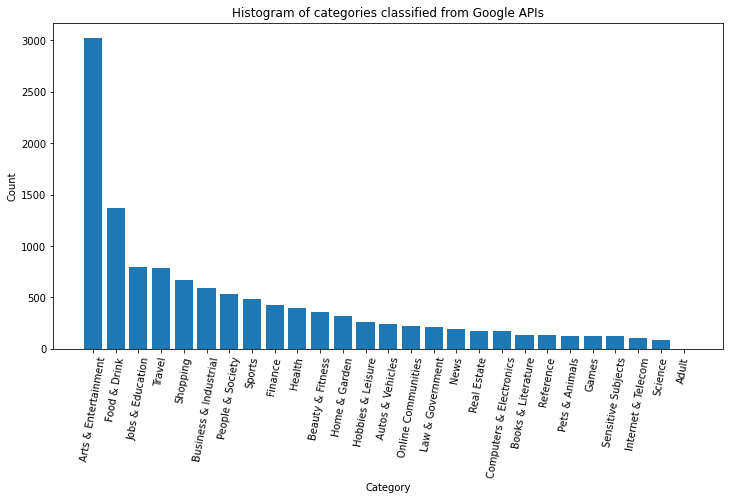

In [17]:
plt.figure(figsize=(12, 6))
x_axis = list(range(len(classified_categories_counts)))
plt.bar(x_axis, classified_categories_counts)
plt.xticks(ticks=x_axis, labels=classified_categories_labels, rotation=80)
plt.title("Histogram of categories classified from Google APIs", fontsize=12)
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

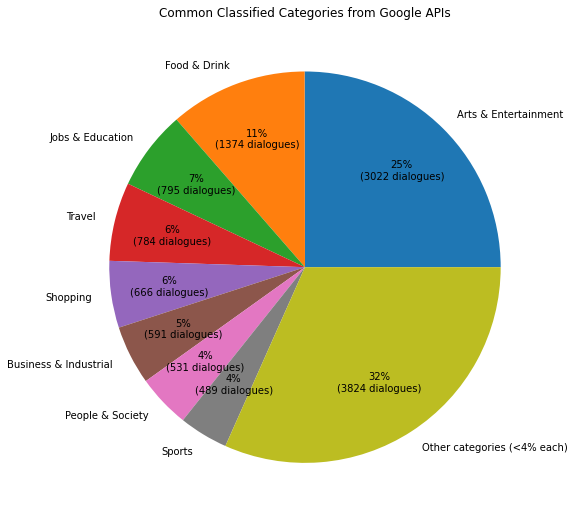

In [18]:
# remove all categories below 4%

cleaned_labels, cleaned_counts = [], []
other_count = 0
for label, count in zip(classified_categories_labels, classified_categories_counts):
    if count/len(dataset_df[not_nan_mask]) > 0.04:
        cleaned_labels.append(label)
        cleaned_counts.append(count)
    
    else:
      other_count += count

cleaned_labels.append("Other categories (<4% each)")
cleaned_counts.append(other_count)
formatter = lambda x, total=len(dataset_df[not_nan_mask]):'{:.0f}%\n({:.0f} dialogues)'.format(x, np.ceil(total*(x/100)))

plt.figure(figsize=(9, 9))
plt.pie(cleaned_counts, labels=cleaned_labels, autopct=formatter, pctdistance=0.7, labeldistance=1.1)
plt.title("Common Classified Categories from Google APIs", fontsize=12)
plt.show()